In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras import layers, models, optimizers, callbacks, applications, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os
import random
import shutil
from keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import (
    Accuracy, Precision, Recall, AUC, BinaryAccuracy,
    FalsePositives, FalseNegatives, TruePositives, TrueNegatives
)


### Set The Configrations

In [2]:
# ======== CONFIG ========
TRAIN_DIR = "/mnt/d/01_Projects/CV/teeth_classification/data/raw/Training"
TEST_DIR = "/mnt/d/01_Projects/CV/teeth_classification/data/raw/Testing"
VAL_DIR = "/mnt/d/01_Projects/CV/teeth_classification/data/raw/Validation"
RAW = "/mnt/d/01_Projects/CV/teeth_classification/data/raw"
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS_BASELINE = 35
EPOCHS_TRANSFER = 15



# Get the count of each class of the dataset

In [3]:
def class_counts(folder):
    counts = {}
    for class_name in sorted(os.listdir(folder)):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([image for image in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, image))])
    return counts

In [4]:
class_counts(TRAIN_DIR)

{'CaS': 480,
 'CoS': 450,
 'Gum': 359,
 'MC': 540,
 'OC': 324,
 'OLP': 540,
 'OT': 393}

In [5]:
class_counts(TEST_DIR)

{'CaS': 160,
 'CoS': 149,
 'Gum': 120,
 'MC': 180,
 'OC': 108,
 'OLP': 180,
 'OT': 131}

In [6]:
class_counts(VAL_DIR)

{'CaS': 160,
 'CoS': 149,
 'Gum': 119,
 'MC': 180,
 'OC': 108,
 'OLP': 180,
 'OT': 131}

### 📁 Data Loading Pipeline
We use `image_dataset_from_directory` to build an efficient data pipeline.

**Key Parameters:**
* **Directory:** Loaded from `${TRAIN_DIR}`.
* **Image Size:** Resized to `${IMAGE_SIZE}` to match the model input layer.
* **Batch Size:** Set to `9` for visualization and memory efficiency.
* **Shuffling:** Enabled to ensure the model doesn't learn the order of the folders.

**Internal Pipeline flow:**
`Disk (Files) -> Decode Pixels -> Resize -> Batching -> GPU`

*Note: This method is preferred over `ImageDataGenerator` as it leverages the `tf.data` API for faster performance and better integration with Keras 3.*

In [7]:
train_sample = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = IMAGE_SIZE,
    batch_size = 9,
    shuffle = True
)
train_sample

Found 3086 files belonging to 7 classes.


2026-02-15 23:19:42.274170: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = train_sample.class_names
class_names

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

In [9]:
for images, labels in train_sample.take(1):
  print(labels)

tf.Tensor([5 3 2 4 0 1 6 6 2], shape=(9,), dtype=int32)


2026-02-15 23:19:42.802554: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-02-15 23:19:43.159121: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


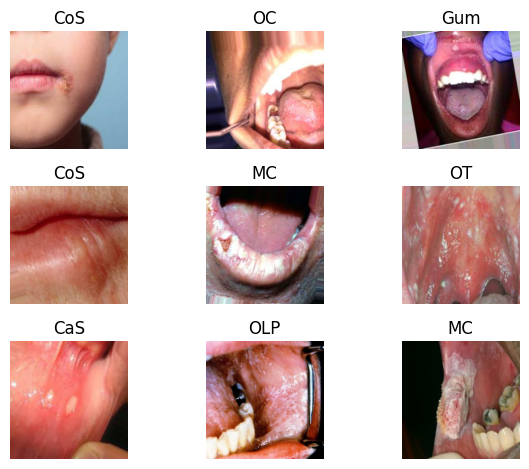

In [10]:
for images, labels in train_sample.take(1): # Get one batch from the data >> take(1) return >>  (images>>pixels), (labels>>classes)
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

plt.tight_layout()

# LOAD AND PREPARE DATA

### 🧠 Choice of Label Mode: Integer vs. Categorical

In this project, we utilize `label_mode='int'` within our data loading pipeline. This choice significantly impacts memory efficiency and model configuration.

#### 1. Memory & Storage Efficiency
* **Integer Mode:** Represents each class as a single number (e.g., `3`). This is extremely lightweight for the system RAM.
* **Categorical Mode:** Uses "One-Hot" vectors (e.g., `[0, 0, 0, 1, 0]`). For a dataset with many classes, storing these vectors for every image can lead to unnecessary memory overhead.

#### 2. Notebook Workflow Impact
* **Data Inspection:** When we run `print(labels)`, we see a clear list of numbers like `[0, 2, 1]`, making it easy to verify class assignments.
* **Loss Function:** Setting the mode to `'int'` forces us to use `SparseCategoricalCrossentropy` during model compilation.
* **Final Layer:** The output layer of the model remains the same (e.g., `Dense(num_classes, activation='softmax')`), but the "True" labels it compares against will be single integers.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    #labels = "inferred", # It tells the function to look at my folder names to determine the labels
    label_mode = "int",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_names = class_names

)

Found 3086 files belonging to 7 classes.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels = "inferred",
    label_mode = "int",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_names = class_names
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels = "inferred",
    label_mode = "int",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_names = class_names
)

Found 1027 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


**these methods ensure your GPU isn't sitting idle waiting for the CPU to finish processing images**

### 1. .cache() (In-Memory Storage)
**How it works:** During the first epoch, the images are read from the disk and decoded. This processed data is then stored in the system's RAM.

**Benefit:** In all following epochs, the model pulls data directly from memory instead of the hard drive, which is significantly faster and prevents the "Disk I/O" bottleneck.

### 2. .prefetch() (Parallel Execution)
How it works: This allows the CPU to prepare Batch N+1 while the GPU is still training on Batch N.

AUTOTUNE: We use tf.data.AUTOTUNE, which allows TensorFlow to dynamically manage the buffer size based on available CPU/GPU resources.

Benefit: This overlaps the data preprocessing and model execution, ensuring the GPU is never idle.

In [13]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


# Preprocessing and Augmentation

In [14]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomBrightness(factor=0.2)
])

2026-02-15 23:19:49.092347: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


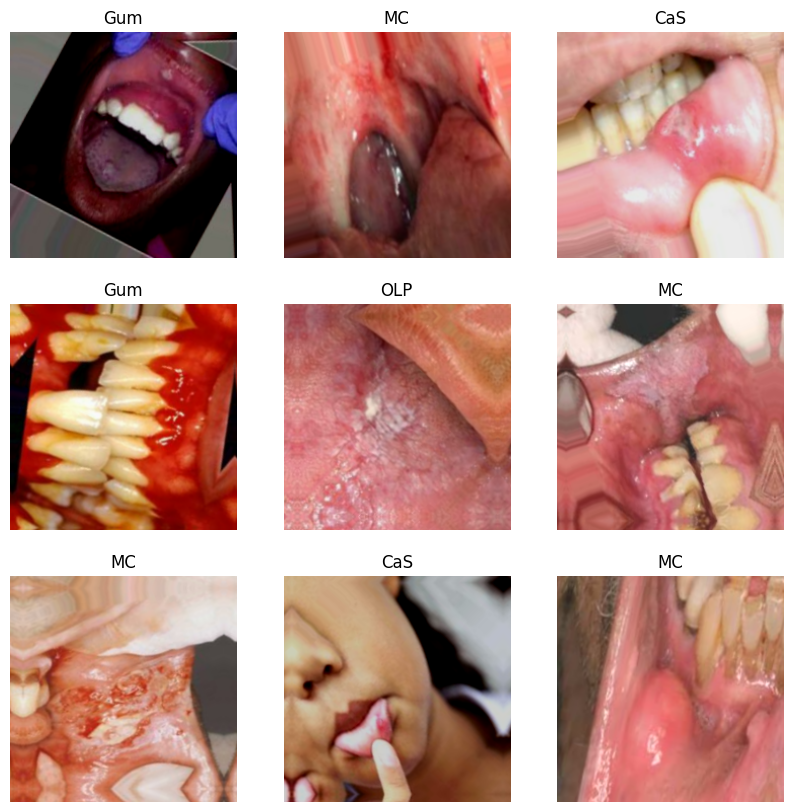

In [15]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1): # get one batch of images from the train ds
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))  # keras expect a batch of images not a single image this turns an image of shape (224,224,3) into (1,224,224,3)
        augmented_image = augmented_image[0]  # remove batch dim back
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


In [16]:
normalization = layers.Rescaling(1./255)

# Build CNN Model

# 🧠 CNN Inference and Theory Guide: From Pixels to Probabilities

This guide breaks down the technical process of how our Computer Vision model processes a single image, calculates raw scores (logits), and converts them into human-readable medical classifications.

---

## 1. Single Image Inference Pipeline

When we test a single image, we follow a specific sequence to match the format the model saw during training.

### Step-by-Step Function Breakdown

* **`img_to_array`**: Converts the loaded PIL image into a NumPy array of shape . This turns visual pixels into a 3D matrix of numbers.
* **`np.expand_dims`**: Adds a **Batch Dimension**, changing the shape to . Keras models always expect a batch, even for a single image.
* **`model.predict()`**: Returns a 2D array of probabilities (e.g., `[[0.1, 0.8, ...]]`).
* **`np.argmax()`**: Identifies the index of the highest probability (the "winner").
* **Decoding**: We use a reversed dictionary of `class_indices` to map that index back to a label like `'CoS'`.

---

## 2. Model Evaluation vs. Prediction

It is important to distinguish between these two Keras methods:

| Feature | `model.predict()` | `model.evaluate()` |
| --- | --- | --- |
| **Primary Output** | The actual prediction values (probabilities) | Scalar values (Loss and Accuracy) |
| **Requires Labels?** | No | Yes |
| **Goal** | Inference: "What is in this image?" | Assessment: "How accurate is my model?" |

---

## 3. The Mathematics of "Softmax"

The final layer of the network outputs a **Probability Distribution**.

### How it works:

1. **Exponential ():** Each raw score (logit) is raised to the power of . This makes all numbers positive and amplifies the differences between scores.
2. **Normalization:** Each value is divided by the sum of all values.
3. **Result:** Every output is between 0 and 1, and the entire array sums to exactly **1.0 (100%)**.

---

## 4. Understanding "Logits"

**Logits** are the raw, unfiltered "votes" produced by the last `Dense` layer before the Softmax activation.

* **Calculation:**
* **Meaning:** A higher logit for a class means the model found more "evidence" (features) for that specific class.
* **Role in `build_CNN`:** In your code, the logits are generated inside the `layers.Dense(num_classes, activation="softmax")` layer. The linear math happens first (Logit), followed immediately by the squashing function (Softmax).

---

## 5. CNN Simulation: Pixel Journey

Here is the transformation path for your `build_CNN` architecture:

### A. Feature Extraction

* **Conv2D:** Filters scan the image for medical textures/edges.
* **MaxPooling:** Reduces dimensions  to focus on the most important features.
* **BatchNormalization:** Keeps the data "centered" for faster, more stable training.

### B. The Bottleneck

* **GlobalAveragePooling2D (GAP):** Condenses the final  feature maps into a single vector of **128 numbers**. Each number represents the "strength" of a specific feature found across the whole image.

### C. The Decision

* **Dropout:** Randomly shuts off  of neurons to prevent the model from "memorizing" specific training images (overfitting).
* **Dense Layer:** Maps those 128 features to **7 Logits** (one for each medical category).
* **Softmax:** Converts those 7 Logits into final **Confidence Scores**.



In [17]:
def build_CNN(input_shape = (224,224,3), num_classes = 7):
  # Input
    inputs = layers.Input(shape=input_shape)
    # Initial processing
    x = data_augmentation(inputs)
    x = normalization(x)
    # Feature Extraction
    x = layers.Conv2D(32,3, padding = "same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

In [18]:
CNN = build_CNN()

In [19]:
CNN.compile(
    optimizer = optimizers.Adam(learning_rate=1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics= ["accuracy"]
)
CNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,143 (949.78 KB)

 Trainable params: 242,439 (947.03 KB)

 Non-trainable params: 704 (2.75 KB)

# Callbacks

In [20]:
save_model = "/kaggle/working/"


In [21]:
save_model + "/" + "CNN_Base_model" + ".keras"

'/kaggle/working//CNN_Base_model.keras'

In [22]:
def get_callbacks(model_name):
  callbacks = []
  rl = ReduceLROnPlateau(monitor="val_accuracy",
                         patience=5,
                         verbose=1,
                         factor=0.5,
                         min_lr=0.00001)
  callbacks.append(rl)
  early_stopping = EarlyStopping(monitor="val_accuracy",
                                 patience=10,
                                 verbose=1,
                                 mode="max")

  callbacks.append(early_stopping)
  checkpoint = ModelCheckpoint(filepath=save_model + "/" + model_name + ".keras",
                               monitor= "val_accuracy",
                               mode="max",
                               save_best_only=True)
  callbacks.append(checkpoint)

  return callbacks

# Train The CNN Model

In [105]:
my_callbacks = get_callbacks(model_name="CNN_model")
history_CNN = CNN.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS_BASELINE,
    callbacks=my_callbacks,
)

Epoch 1/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5862 - loss: 1.1212 - val_accuracy: 0.6115 - val_loss: 1.0813 - learning_rate: 2.5000e-05
Epoch 2/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.6060 - loss: 1.1138 - val_accuracy: 0.6319 - val_loss: 1.0531 - learning_rate: 2.5000e-05
Epoch 3/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5913 - loss: 1.1202 - val_accuracy: 0.5560 - val_loss: 1.1924 - learning_rate: 2.5000e-05
Epoch 4/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5852 - loss: 1.1233 - val_accuracy: 0.5784 - val_loss: 1.1452 - learning_rate: 2.5000e-05
Epoch 5/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.6095 - loss: 1.1016 - val_accuracy: 0.6232 - val_loss: 1.0698 - learning_rate: 2.5000e-05
Epoch 6/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.6082 - loss: 1.0819 - val_accuracy: 0.6203 - val_loss: 1.0695 - learning_rate: 2.5000e-05
Epoch 7/35
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

# Evaluate the CNN

In [ ]:
CNN_model = load_model("/mnt/d/01_Projects/CV/teeth_classification/models/CNN_model.keras")


In [25]:
CNN_model.evaluate(test_ds)


65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 461ms/step - accuracy: 0.6556 - loss: 0.9809


[0.9808929562568665, 0.655642032623291]

In [26]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_prob = CNN_model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)


2026-02-15 23:22:07.630289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 386ms/step


In [27]:
class_names = sorted(os.listdir(TRAIN_DIR))
print(class_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [28]:
print(classification_report(y_true, y_pred, target_names = class_names))


              precision    recall  f1-score   support

         CaS       0.71      0.72      0.72       160
         CoS       0.65      0.89      0.75       149
         Gum       0.83      0.71      0.77       120
          MC       0.68      0.57      0.62       180
          OC       0.43      0.86      0.57       108
         OLP       0.74      0.52      0.61       180
          OT       0.78      0.40      0.53       131

    accuracy                           0.66      1028
   macro avg       0.69      0.67      0.65      1028
weighted avg       0.69      0.66      0.65      1028



In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
cm

array([[116,  22,   5,   1,  13,   2,   1],
       [ 14, 132,   0,   0,   2,   1,   0],
       [ 15,   1,  85,   8,   6,   4,   1],
       [  1,  10,   9, 103,  42,  13,   2],
       [  0,   6,   0,   5,  93,   4,   0],
       [  7,   9,   2,  22,  36,  93,  11],
       [ 10,  22,   1,  13,  24,   9,  52]])

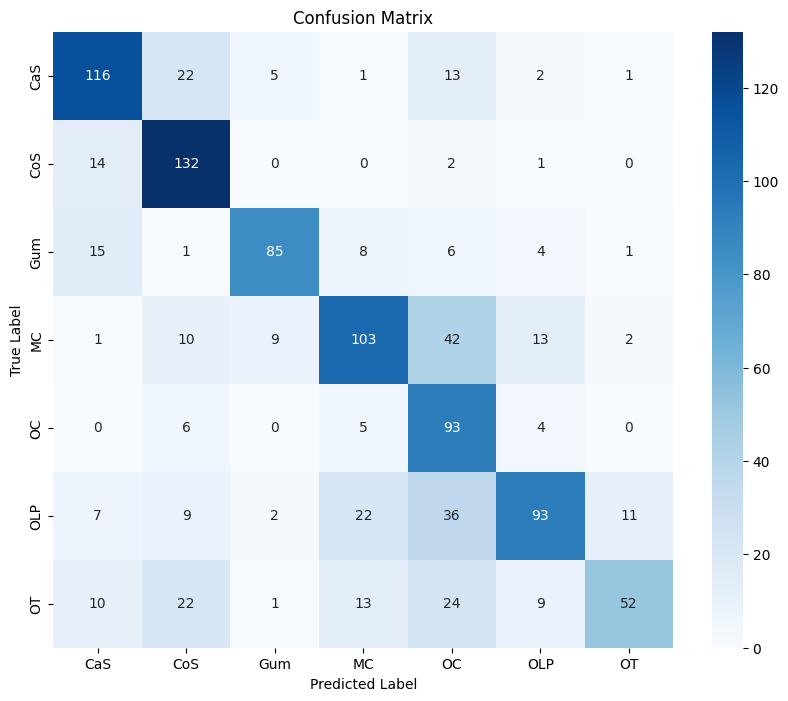

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
acc = history_CNN.history["accuracy"]
val_acc = history_CNN.history["val_accuracy"]
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
#Train and validation loss
loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model on one image

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


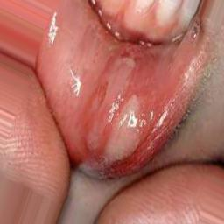

In [32]:
img_path = "/mnt/d/01_Projects/CV/teeth_classification/data/raw/Training/CaS/a_79_0_2654.jpg"
img = load_img(img_path, target_size=(224,224))
img

In [33]:
img_array = img_to_array(img)
print(img_array) # The output will be a 3D matrix

[[[227. 118. 111.]
  [228. 119. 112.]
  [229. 120. 113.]
  ...
  [178. 149. 131.]
  [173. 146. 127.]
  [171. 144. 125.]]

 [[226. 117. 110.]
  [227. 118. 111.]
  [228. 119. 112.]
  ...
  [177. 148. 130.]
  [173. 146. 127.]
  [171. 144. 125.]]

 [[224. 117. 111.]
  [224. 117. 111.]
  [226. 119. 113.]
  ...
  [176. 147. 131.]
  [174. 147. 130.]
  [172. 145. 128.]]

 ...

 [[163. 107.  94.]
  [163. 107.  94.]
  [163. 107.  94.]
  ...
  [226. 160. 148.]
  [221. 155. 143.]
  [217. 151. 139.]]

 [[163. 107.  94.]
  [163. 107.  94.]
  [162. 106.  93.]
  ...
  [228. 164. 154.]
  [225. 161. 151.]
  [223. 159. 149.]]

 [[163. 107.  94.]
  [163. 107.  94.]
  [162. 106.  93.]
  ...
  [231. 167. 157.]
  [230. 166. 156.]
  [229. 165. 155.]]]


In [34]:
img_array.shape # here we have 3 dim (H,W,Channel)

(224, 224, 3)

In [35]:
img_batch = np.expand_dims(img_array, axis=0)
print(img_batch) # The output will be a 4D matrix

[[[[227. 118. 111.]
   [228. 119. 112.]
   [229. 120. 113.]
   ...
   [178. 149. 131.]
   [173. 146. 127.]
   [171. 144. 125.]]

  [[226. 117. 110.]
   [227. 118. 111.]
   [228. 119. 112.]
   ...
   [177. 148. 130.]
   [173. 146. 127.]
   [171. 144. 125.]]

  [[224. 117. 111.]
   [224. 117. 111.]
   [226. 119. 113.]
   ...
   [176. 147. 131.]
   [174. 147. 130.]
   [172. 145. 128.]]

  ...

  [[163. 107.  94.]
   [163. 107.  94.]
   [163. 107.  94.]
   ...
   [226. 160. 148.]
   [221. 155. 143.]
   [217. 151. 139.]]

  [[163. 107.  94.]
   [163. 107.  94.]
   [162. 106.  93.]
   ...
   [228. 164. 154.]
   [225. 161. 151.]
   [223. 159. 149.]]

  [[163. 107.  94.]
   [163. 107.  94.]
   [162. 106.  93.]
   ...
   [231. 167. 157.]
   [230. 166. 156.]
   [229. 165. 155.]]]]


In [37]:
# Why we expand the dim of the images ???
# because tensorflow and keras models expect that the imput images is 4D not 3D

In [38]:
img_batch.shape # You can see that after expand the dim of the img_array we a new dim for the batch
# (Batch size, Height, width, Channels) the (one) tells tensorflow that this batch contain only 1 image

(1, 224, 224, 3)

In [ ]:
probabilties = CNN_model.predict(img_batch)
probabilties
# The output of predictions on the img is a probabilty distribution because >> the confidence for each class >> sum of them equal 1
# We used Softmax Activation function

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


array([[0.2607084 , 0.31203455, 0.02940668, 0.09346184, 0.21651705,
        0.04463736, 0.04323426]], dtype=float32)

In [40]:
predicted_index = np.argmax(probabilties)
predicted_index
# The np.argmax() get the index of the largest probabilty so in this case
# The largest probabilty is 0.4865033 (confidence) it's index is 1

1

**What is "Confidence"?
Confidence is simply the "strength" of the model's highest prediction.**

Calculation: np.max(predictions) extracts the actual value of the highest probability found by argmax.

Interpretation: Using our example, the confidence is 0.45 (or 48%). It tells you how sure the model is that the image belongs to the predicted class.

In [41]:
confidence = np.max(probabilties)
confidence

0.31203455

In [42]:
class_names = train_sample.class_names
class_names

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

In [43]:
for i, name in enumerate(class_names):
   print(i,name)

0 CaS
1 CoS
2 Gum
3 MC
4 OC
5 OLP
6 OT


In [44]:
class_indices = {name: i for i, name in enumerate(class_names)}
class_indices

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [45]:
# Reverse the class_indices dict to get the class name from the index
labels = {v: k for k, v in class_indices.items()}
labels

{0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}

In [46]:
labels[1]

'CoS'

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_single_image(model, image_path, true_label, class_indices):
    """
    Predicts the class of a single image and checks if it matches the true label.

    Args:
        model: The trained Keras model.
        image_path (str): Path to the image file.
        true_label (str): The actual class name of the image (ground truth).
        class_indices (dict): Dictionary mapping class names to indices (e.g., {'CaS': 0, 'Cos': 1, 'Gum':2}).
    """

    # 1. Load and Preprocess the Image
    # target_size must match your training input (e.g., 224x224)
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)

    # Add batch dimension (1, 224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0)

    # 2. Make Prediction
    predictions = model.predict(img_batch, verbose=0) # Get the probabilty dis for the 7 classes
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # 3. Decode the Prediction
    # Reverse the class_indices dictionary to get name from index
    labels = {v: k for k, v in class_indices.items()}
    predicted_class = labels[predicted_index]

    # 4. Check Result
    is_correct = (predicted_class == true_label)
    result_color = 'green' if is_correct else 'red'
    result_text = "CORRECT" if is_correct else "WRONG"

    # 5. Visualize
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label} | Pred: {predicted_class}\n"
              f"Confidence: {confidence:.2%}\n"
              f"Result: {result_text}",
              color=result_color, fontweight='bold')
    plt.show()

    return is_correct

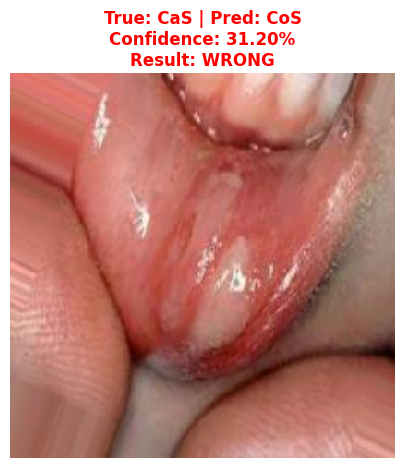

False

In [48]:
# # 1. Get your class dictionary
# # Create class_indices from the class_names list which was already defined.
class_indices = {name: i for i, name in enumerate(class_names)}

# # 2. Define the image path and what it ACTUALLY is
actual_class = "CaS" # Replace with the real class name

# 3. Run the test
test_single_image(CNN_model, img_path, actual_class, class_indices)

# 🧠 CNN Architecture Upgrade: Breaking the 70% Accuracy Barrier

To push the model's performance beyond our previous **70% baseline**, we transitioned the network's classification head from a `GlobalAveragePooling2D` approach to a `Flatten` and multi-layer `Dense` approach. This allows the model to retain critical spatial relationships in the images rather than averaging them away. 

To prevent the massive overfitting that typically happens when using `Flatten`, several protective architectural changes were implemented:

#### 1. Addition of a 5th Convolutional Block (Spatial Reducer)
* **What changed:** Added a final `Conv2D(256)` + `BatchNorm` + `MaxPooling2D` block before flattening.
* **Why it matters:** By the end of the 4th block, our feature map was 14x14. Flattening that directly would create an unmanageable number of parameters. This 5th block safely shrinks the spatial grid down to 7x7, keeping the parameter count highly optimized while extracting the deepest, most complex features.

#### 2. Increased Filter Capacity
* **What changed:** Upgraded the deeper convolutional layers to `256` filters.
* **Why it matters:** Medical images often require the model to recognize highly intricate textures and tiny anomalies. Doubling the filter count in the deep layers gives the network the capacity to learn these complex representations.



#### 3. The `Flatten` Transition
* **What changed:** Replaced `GlobalAveragePooling2D` with `Flatten`.
* **Why it matters:** Global Average Pooling takes an entire feature map and crushes it into a single average number. Flattening unrolls the grid into a 1D line. This forces the Dense layers to care about *where* a feature appeared in the image, not just *if* it appeared.

#### 4. The Deep Dense Head (Classifier)
* **What changed:** Built a robust classification head using two Dense layers (512 neurons and 128 neurons).
* **Why it matters:** Instead of mapping features directly to the output classes, these intermediate layers act as a dedicated "decision-making" network. They combine the raw visual features extracted by the convolutions into logical conclusions.

#### 5. Aggressive Regularization (The Safety Net)
* **What changed:** Introduced **L2 Regularization** (`kernel_regularizer=regularizers.l2(0.001)`) in the Dense layers, combined with **Batch Normalization** and high **Dropout** (0.5 and 0.4).
* **Why it matters:** Because `Flatten` creates dense, fully connected webs of parameters, the model is highly prone to memorizing the training data. L2 penalizes large weights, Batch Norm stabilizes the signal, and Dropout forces neurons to learn independently. Together, they force the model to generalize to unseen data, improving validation accuracy.

In [50]:

def build_CNN_improved(input_shape=(224, 224, 3), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    
    # Initial processing
    x = data_augmentation(inputs)
    x = normalization(x)
    
    # Block 1
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x) # Reduces to 112x112
    
    # Block 2
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x) # Reduces to 56x56
    
    # Block 3
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x) # Reduces to 28x28
    
    # Block 4 - Increased filters for deeper feature extraction
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x) # Reduces to 14x14
    
    # Block 5 - CRITICAL for safe flattening
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x) # Reduces to 7x7
    
    # --- Transition ---
    x = layers.Flatten()(x) # Now flattens 7x7x256 = 12,544 (Much safer!)
    
    # --- New Dense Network ---
    # Dense 1: Added L2 Regularization to fight overfitting
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) # High dropout needed after Flatten
    
    # Dense 2: Additional representation layer
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return models.Model(inputs, outputs)

In [51]:
CNN_Improved = build_CNN_improved()

In [52]:
CNN_Improved.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             

 Total params: 7,473,607 (28.51 MB)

 Trainable params: 7,470,855 (28.50 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [53]:
CNN_Improved.compile(
    optimizer = optimizers.Adam(learning_rate=1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics= ["accuracy"]
)


In [54]:
cnn_improved_callbacks = get_callbacks(model_name="CNN_Improved_model")

In [31]:
history_CNN_Improved = CNN_Improved.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks=cnn_improved_callbacks
)

Epoch 1/20


I0000 00:00:1771008364.848110     130 cuda_dnn.cc:529] Loaded cuDNN version 91002


193/193 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.2436 - loss: 3.7826 - val_accuracy: 0.1451 - val_loss: 7.2109 - learning_rate: 1.0000e-04
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.3031 - loss: 3.3858 - val_accuracy: 0.1451 - val_loss: 8.8158 - learning_rate: 1.0000e-04
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.3337 - loss: 3.2263 - val_accuracy: 0.3612 - val_loss: 3.2310 - learning_rate: 1.0000e-04
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.3585 - loss: 3.1161 - val_accuracy: 0.5560 - val_loss: 2.4045 - learning_rate: 1.0000e-04
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.3996 - loss: 3.0262 - val_accuracy: 0.5161 - val_loss: 2.5539 - learning_rate: 1.0000e-04
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.3905 - loss: 2.9834 - val_accuracy: 0.5024 - val_loss: 2.4893 - learning_rate: 1.0000e-04
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accura

In [36]:
history_2_CNN_Improved = CNN_Improved.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Set to the NEW total number of epochs (20 + 10)
    initial_epoch=history_CNN_Improved.epoch[-1] + 1, # Tells Keras to start counting at Epoch 21
    callbacks=cnn_improved_callbacks
)

Epoch 21/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5921 - loss: 2.2020 - val_accuracy: 0.7020 - val_loss: 1.8784 - learning_rate: 1.0000e-04
Epoch 22/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.6146 - loss: 2.1677 - val_accuracy: 0.6621 - val_loss: 2.0173 - learning_rate: 1.0000e-04
Epoch 23/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.6247 - loss: 2.1192 - val_accuracy: 0.7887 - val_loss: 1.7078 - learning_rate: 1.0000e-04
Epoch 24/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.6370 - loss: 2.0887 - val_accuracy: 0.7498 - val_loss: 1.7110 - learning_rate: 1.0000e-04
Epoch 25/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.6582 - loss: 2.0253 - val_accuracy: 0.7478 - val_loss: 1.7275 - learning_rate: 1.0000e-04
Epoch 26/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.6546 - loss: 2.0115 - val_accuracy: 0.6563 - val_loss: 2.1180 - learning_rate: 1.0000e-04
Epoch 27/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 7

In [55]:
from keras.models import load_model
CNN_Improved_Model = load_model("/mnt/d/01_Projects/CV/teeth_classification/models/Best_Model_CNN.keras")


In [56]:
CNN_Improved_Model.evaluate(test_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 462ms/step - accuracy: 0.9436 - loss: 1.0850


[1.0850112438201904, 0.9435797929763794]

In [57]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_prob = CNN_Improved_Model.predict(test_ds)


65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step


In [58]:
y_pred = np.argmax(y_prob, axis=1)
class_names= sorted(os.listdir(TRAIN_DIR))


In [59]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names = class_names))


              precision    recall  f1-score   support

         CaS       0.99      0.97      0.98       160
         CoS       0.98      0.99      0.99       149
         Gum       0.96      0.99      0.98       120
          MC       0.89      0.93      0.91       180
          OC       0.89      0.85      0.87       108
         OLP       0.96      0.89      0.93       180
          OT       0.92      0.98      0.95       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



In [60]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[155,   0,   3,   1,   1,   0,   0],
       [  0, 148,   1,   0,   0,   0,   0],
       [  0,   0, 119,   1,   0,   0,   0],
       [  0,   1,   0, 167,   6,   3,   3],
       [  0,   2,   0,  10,  92,   3,   1],
       [  1,   0,   1,   7,   3, 161,   7],
       [  0,   0,   0,   2,   1,   0, 128]])

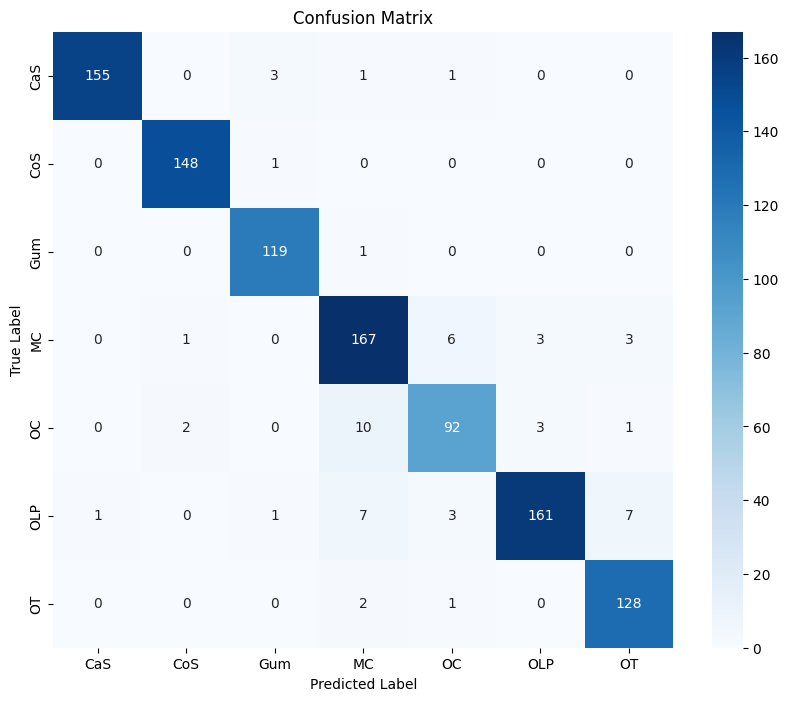

In [61]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names
           )
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

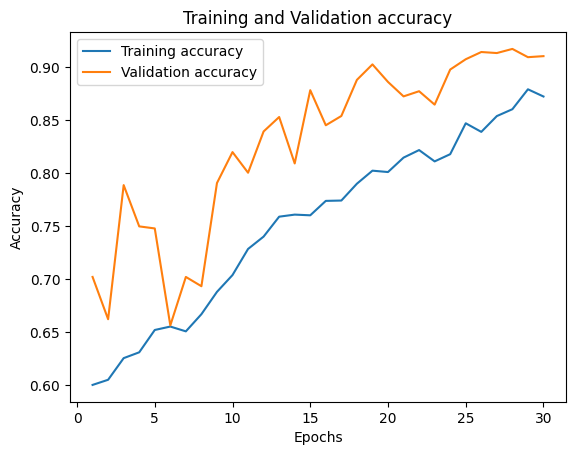

In [46]:
acc = history_2_CNN_Improved.history["accuracy"]
val_acc = history_2_CNN_Improved.history["val_accuracy"]
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

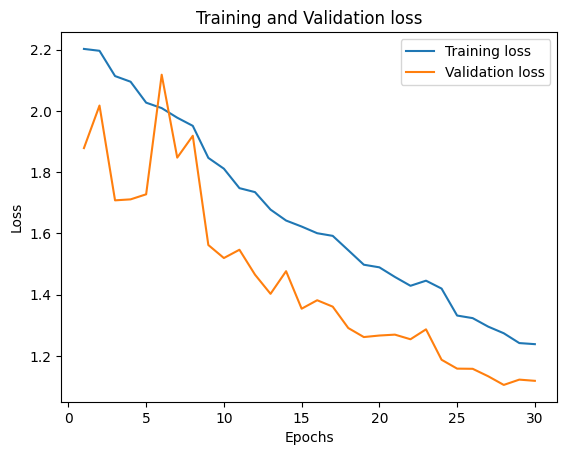

In [47]:
loss = history_2_CNN_Improved.history['loss']
val_loss = history_2_CNN_Improved.history['val_loss']
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# from IPython.display import FileLink

# # Replace with your actual model name if it's different
# FileLink(r'CNN_Improved_model.keras')

/kaggle/working/CNN_Improved_model.keras

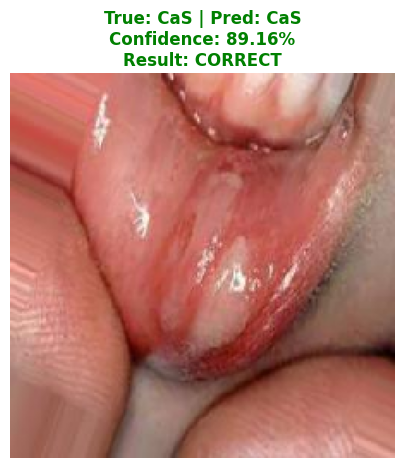

True

In [62]:
# # 2. Define the image path and what it ACTUALLY is
actual_class = "CaS" # Replace with the real class name
class_indices = {name: i for i, name in enumerate(class_names)}

# 3. Run the test
test_single_image(CNN_Improved_Model, img_path, actual_class, class_indices)

# Train EfficientNetB0

In [ ]:
#preprocess_layer = tf.keras.applications.efficientnet.preprocess_input
#def build_eff_net(num_classes=7):
   # inputs = layers.Input(shape=(224,224,3))

    #x = data_augmentation(inputs)
    #x = layers.Rescaling(1./255)(x)
    #eff_net = EfficientNetB0(include_top=False, weights="imagenet", input_shape= (224,224,3))
    #eff_net.trainable=False

   # x = eff_net(x, training=False)
   # x = layers.GlobalAveragePooling2D()(x)
   # outputs = layers.Dense(len(class_names), activation="softmax",
                    #      dtype= "float32",
                       #   kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

   # return models.Model(inputs, outputs)

In [ ]:
# eff_model = build_eff_net()

In [64]:
# We set (include_top=Fasle) to deactivate the head of the model and customize the head on our 7 classes
 # weights= "imagenet" >> This loads the weights that's the model have already trained on it by Google
 #eff_net.trainable=False >> That's (freezes) the

# 1. Define the backbone
eff_net = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3))
eff_net.trainable = False

# 2. Build the Functional Model
inputs = layers.Input(shape=(*IMAGE_SIZE, 3))

# Step A: Augmentation (Your finished work)
x = data_augmentation(inputs) 

# Step B: Preprocessing (The correct way to include it)
x = layers.Lambda(preprocess_input, name="efficientnet_preprocessor")(x)

# Step C: Feature Extraction
x = eff_net(x, training=False)

# Step D: Flattening and Regularization
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# Step E: Final Decision
outputs = layers.Dense(len(class_names), 
                       activation="softmax",
                       dtype="float32",
                       kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

eff_model = models.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 20s 1us/step


In [65]:
callbacks= get_callbacks("EfficientNetB0")

# Ensure the model is compiled with the correct loss function right before training
optimizer = Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    amsgrad=False          )

In [66]:
eff_model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", # Using sparse_categorical_crossentropy for integer labels
              metrics=["accuracy"]
              )

In [21]:



Eff_net_history = eff_model.fit(train_ds,
                   epochs=50,
                   validation_data=val_ds,
                   callbacks=callbacks,
                   verbose=1)

Epoch 1/50


E0000 00:00:1770996905.268998    1312 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1770996908.054611    1383 cuda_dnn.cc:529] Loaded cuDNN version 91002


193/193 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.3247 - loss: 1.7387 - val_accuracy: 0.5764 - val_loss: 1.2022 - learning_rate: 5.0000e-04
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5733 - loss: 1.1989 - val_accuracy: 0.6446 - val_loss: 1.0082 - learning_rate: 5.0000e-04
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.6312 - loss: 1.0485 - val_accuracy: 0.7030 - val_loss: 0.9033 - learning_rate: 5.0000e-04
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.6765 - loss: 0.9513 - val_accuracy: 0.7322 - val_loss: 0.8285 - learning_rate: 5.0000e-04
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7053 - loss: 0.8724 - val_accuracy: 0.7527 - val_loss: 0.7755 - learning_rate: 5.0000e-04
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7159 - loss: 0.8282 - val_accuracy: 0.7722 - val_loss: 0.7280 - learning_rate: 5.0000e-04
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accurac

In [67]:
eff_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet_preprocessor       │ (None, 224, 224, 3)    │             0 │
│ (Lambda)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Evaluate the EfficientnetB0 model


In [68]:
# To solve the error when we try to load the model it can't recognize the preprocess_input function 
# Didn't now what it do so we use this line of code to tell keras
# Whenever you see the name 'preprocess_input' in the model file, use this specific function that I just imported from the EfficientNet library.
custom_dict = {'preprocess_input': preprocess_input}

In [69]:

Eff_Net_model = load_model("/mnt/d/01_Projects/CV/teeth_classification/models/EfficientNetB0.keras", custom_objects=custom_dict)


In [70]:
Eff_Net_model.evaluate(test_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 817ms/step - accuracy: 0.9047 - loss: 0.3461


[0.34608447551727295, 0.9046692848205566]

In [71]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_prob = Eff_Net_model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)


65/65 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step


In [72]:
class_names = sorted(os.listdir(TRAIN_DIR))
print(class_names)
print(classification_report(y_true, y_pred, target_names = class_names))

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
              precision    recall  f1-score   support

         CaS       0.94      0.94      0.94       160
         CoS       0.96      1.00      0.98       149
         Gum       0.88      0.81      0.84       120
          MC       0.89      0.89      0.89       180
          OC       0.86      0.88      0.87       108
         OLP       0.88      0.89      0.88       180
          OT       0.91      0.91      0.91       131

    accuracy                           0.90      1028
   macro avg       0.90      0.90      0.90      1028
weighted avg       0.90      0.90      0.90      1028



In [74]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[150,   2,   1,   2,   1,   4,   0],
       [  0, 149,   0,   0,   0,   0,   0],
       [  4,   2,  97,   8,   0,   5,   4],
       [  2,   1,   7, 160,   5,   4,   1],
       [  0,   0,   2,   6,  95,   2,   3],
       [  3,   1,   1,   3,   8, 160,   4],
       [  1,   0,   2,   1,   1,   7, 119]])

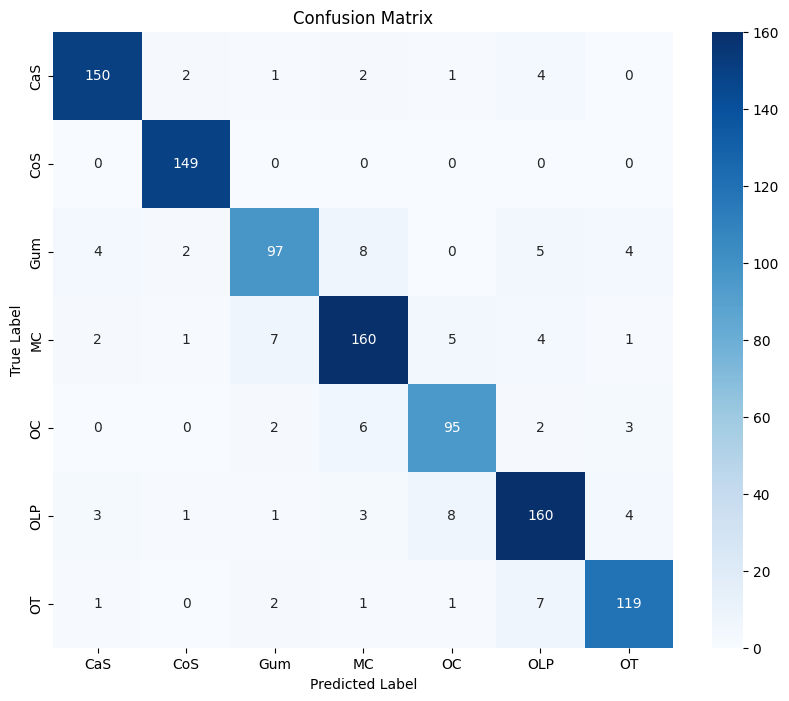

In [75]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


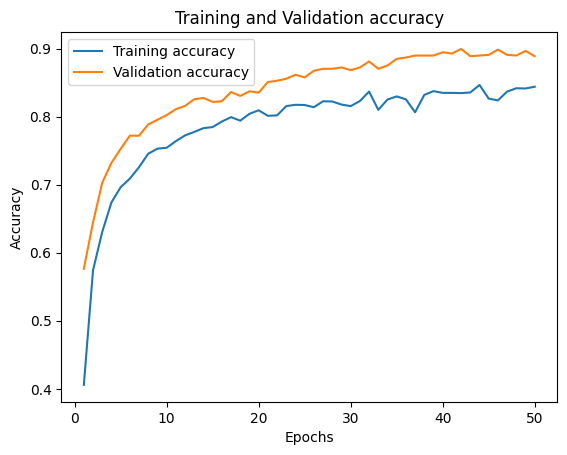

In [40]:
acc = Eff_net_history.history["accuracy"]
val_acc = Eff_net_history.history["val_accuracy"]
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

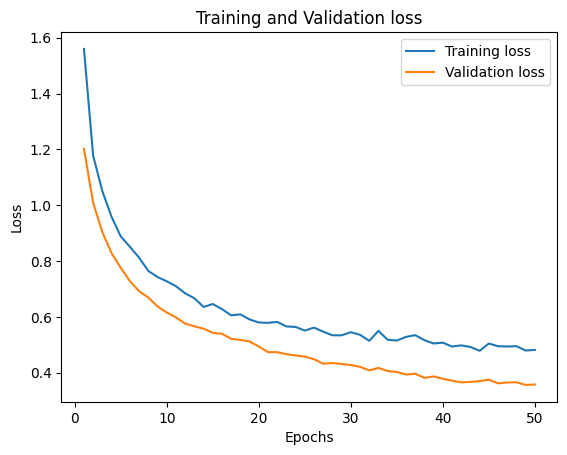

In [41]:
loss = Eff_net_history.history['loss']
val_loss = Eff_net_history.history['val_loss']
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

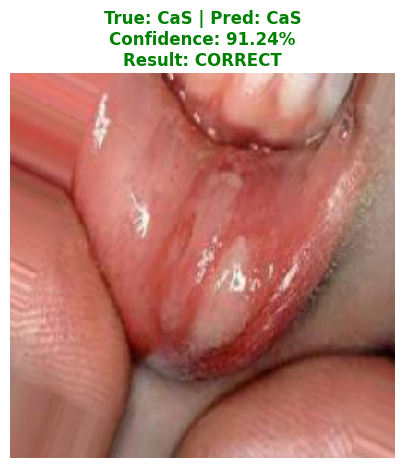

True

In [76]:
# # 2. Define the image path and what it ACTUALLY is
actual_class = "CaS" # Replace with the real class name
class_indices = {name: i for i, name in enumerate(class_names)}

# 3. Run the test
test_single_image(Eff_Net_model, img_path, actual_class, class_indices)

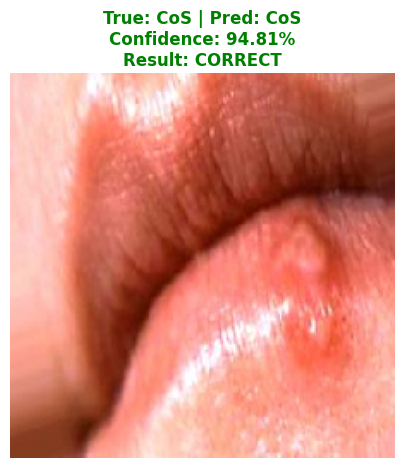

True

In [48]:
actual_class = "CoS"
img_path = "/kaggle/input/teeth-disease-classification/raw/Testing/CoS/b_105_0_6014.jpg"
test_single_image(Eff_Net_model, img_path, actual_class, class_indices)

# Fine tune the Efficient net by unfreeze the top 30% of layers of it

EfficientNet has hundreds of layers. Training all at once can:

Be too slow

Cause overfitting (especially with small dataset)

Break the pre-trained weights if learning rate is too high.

Instead, you unfreeze only the top 30% of layers (the later ones).

Why the later ones? Because:

Early layers detect generic features (edges, textures) → already useful.

Later layers detect task-specific features (shapes, structures) → need adaptation.

### Load the Best model of effiecentnetB0

In [78]:
eff_tuned_path = "/mnt/d/01_Projects/CV/teeth_classification/models/EfficientNetB0_Tuned.keras"
eff_model_tuned = load_model(eff_tuned_path, custom_objects={'preprocess_input': preprocess_input})

In [80]:
len(eff_model_tuned.layers)

7

In [81]:
# 1. Unfreeze the base model
eff_model_tuned.trainable = True

# 2. Calculate the split point (Top 30%)
split_at = int(len(eff_model_tuned.layers) * 0.7)
split_at

4

In [82]:


# 3. Loop through layers to freeze the bottom, BUT keep BatchNormalization frozen everywhere
for layer in eff_model_tuned.layers[:split_at]:
    layer.trainable = False

# EXTRA SAFEGUARD: Force all BatchNormalization layers to stay frozen
# This prevents the "catastrophic forgetting" common in EfficientNet fine-tuning
for layer in eff_model_tuned.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [83]:


# 4. CRITICAL: Re-compile with a VERY LOW learning rate
# Use 1/10th of your original learning rate (e.g., 1e-5)
optimizer = Adam(
    learning_rate=0.0005,  # slightly lower than default for stable training
    beta_1=0.9,            # default, usually leave as is
    beta_2=0.999,          # default, usually leave as is
    epsilon=1e-08,         # slightly lower than default, good for numerical stability
    amsgrad=False           # optional, True can help in some cases
)
eff_model_tuned.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", # Changed to sparse_categorical_crossentropy
              metrics=["accuracy"]
              )

In [ ]:
# 5. Continue Training (Fine-Tuning)
# Note: initial_epoch is important so the plot continues nicely
eff_history_tuned = eff_model_tuned.fit(
    train_ds,
    epochs=20, # Add more epochs (e.g., total_epochs = previous_epochs + 10)
    validation_data=val_ds,
    callbacks=get_callbacks("EfficientNetB0_Tuned")
)

Epoch 1/20


E0000 00:00:1770998844.776190    1312 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


193/193 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.8441 - loss: 0.4721 - val_accuracy: 0.8919 - val_loss: 0.3760 - learning_rate: 5.0000e-04
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8367 - loss: 0.5008 - val_accuracy: 0.8890 - val_loss: 0.3716 - learning_rate: 5.0000e-04
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8451 - loss: 0.4721 - val_accuracy: 0.8880 - val_loss: 0.3700 - learning_rate: 5.0000e-04
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8465 - loss: 0.4701 - val_accuracy: 0.8919 - val_loss: 0.3689 - learning_rate: 5.0000e-04
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8435 - loss: 0.4749 - val_accuracy: 0.8939 - val_loss: 0.3623 - learning_rate: 5.0000e-04
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8552 - loss: 0.4447 - val_accuracy: 0.8851 - val_loss: 0.3773 - learning_rate: 5.0000e-04
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accurac

In [54]:
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_prob = eff_model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred, target_names = class_names))


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step
              precision    recall  f1-score   support

         CaS       0.93      0.97      0.95       160
         CoS       0.99      1.00      0.99       149
         Gum       0.90      0.84      0.87       120
          MC       0.91      0.88      0.89       180
          OC       0.77      0.92      0.84       108
         OLP       0.92      0.82      0.87       180
          OT       0.90      0.92      0.91       131

    accuracy                           0.91      1028
   macro avg       0.90      0.91      0.90      1028
weighted avg       0.91      0.91      0.91      1028



In [55]:
def plot_history(hists, titles=None):
    plt.figure(figsize=(14,5))
    # accuracy
    plt.subplot(1,2,1)
    for h, label in hists:
        plt.plot(h.history['accuracy'], label=label + " train")
        plt.plot(h.history['val_accuracy'], '--', label=label + " val")
    plt.title("Accuracy")
    plt.legend()
    # loss
    plt.subplot(1,2,2)
    for h, label in hists:
        plt.plot(h.history['loss'], label=label + " train")
        plt.plot(h.history['val_loss'], '--', label=label + " val")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history([(eff_history_tuned, "EfficientNetB0_Tuned"), (Eff_net_history, "EfficientNetB0"), (history_CNN, "CNN")])


NameError: name 'history_CNN' is not defined

# Use Dense Net pretrained model